# Inspect the `ETL2` dataset

## Prerequisite

Get and unzip the `ETL2` dataset as show below.

```
ETL2
├── ETL2INFO
├── ETL2_1
├── ETL2_2
├── ETL2_3
├── ETL2_4
└── ETL2_5
```

In [1]:
import os
import time
import math
import re
import struct
import traceback
import codecs

# external dependencies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import bitstring

from PIL import Image
import IPython.display as display

In [2]:
etl2_filepaths = [    
    'ETL2/ETL2_1',
    'ETL2/ETL2_2',
    'ETL2/ETL2_3',
    'ETL2/ETL2_4',
    'ETL2/ETL2_5',
]

etl2_filepaths

['ETL2/ETL2_1', 'ETL2/ETL2_2', 'ETL2/ETL2_3', 'ETL2/ETL2_4', 'ETL2/ETL2_5']

The dataset uses an uncommon encoding (`co59`) to encode the label so we need to prepare a map to convert them to unicode.

The code below was taken from the official guide with the supplement `co59-utf8.txt` file.

In [3]:
t56s = '0123456789[#@:>? ABCDEFGHI&.](<  JKLMNOPQR-$*);\'|/STUVWXYZ ,%="!'

def T56(c):
    return t56s[c]

with codecs.open('co59-utf8.txt', 'r', 'utf-8') as co59f:
    co59t = co59f.read()

co59l = co59t.split()
CO59 = {}
for c in co59l:
    ch = c.split(':')
    co = ch[1].split(',')
    CO59[(int(co[0]), int(co[1]))] = ch[0]

CO59

{(4, 4): '上',
 (8, 4): '下',
 (12, 4): '不',
 (16, 4): '世',
 (20, 4): '両',
 (24, 4): '面',
 (6, 4): '中',
 (10, 4): '主',
 (14, 4): '義',
 (18, 4): '久',
 (22, 4): '予',
 (26, 4): '算',
 (5, 4): '催',
 (9, 4): '優',
 (13, 4): '児',
 (17, 4): '童',
 (21, 4): '先',
 (25, 4): '光',
 (7, 4): '公',
 (11, 4): '共',
 (15, 4): '内',
 (19, 4): '閣',
 (23, 4): '用',
 (27, 4): '同',
 (4, 6): '争',
 (8, 6): '事',
 (12, 6): '井',
 (16, 6): '文',
 (20, 6): '交',
 (24, 6): '夜',
 (6, 6): '変',
 (10, 6): '高',
 (14, 6): '商',
 (18, 6): '人',
 (22, 6): '入',
 (26, 6): '今',
 (5, 6): '岡',
 (9, 6): '次',
 (13, 6): '風',
 (17, 6): '出',
 (21, 6): '切',
 (25, 6): '列',
 (7, 6): '別',
 (11, 6): '制',
 (15, 6): '割',
 (19, 6): '劇',
 (23, 6): '力',
 (27, 6): '加',
 (4, 5): '合',
 (8, 5): '全',
 (12, 5): '化',
 (16, 5): '付',
 (20, 5): '代',
 (24, 5): '伝',
 (6, 5): '件',
 (10, 5): '任',
 (14, 5): '休',
 (18, 5): '位',
 (22, 5): '何',
 (26, 5): '佐',
 (5, 5): '助',
 (9, 5): '労',
 (13, 5): '働',
 (17, 5): '務',
 (21, 5): '医',
 (25, 5): '半',
 (7, 5): '協',
 (11, 5): '反'

In [4]:
len(CO59.keys())

2304

# Take a look a sample file

In [5]:
sample_filepath = etl2_filepaths[0]
sample_filepath

'ETL2/ETL2_1'

In [6]:
file_stream = bitstring.ConstBitStream(filename=sample_filepath)

Each records has the size of 3660 6-bit bytes.

In [7]:
RECORD_LENGTH = 6 * 3660 # in bit(s)

In [8]:
# you can change the skip value to inspect a different record
skip = 0
file_stream.pos = skip * RECORD_LENGTH

Unpack the record as shown in the specification.

http://etlcdb.db.aist.go.jp/specification-of-etl-2

In [9]:
record = file_stream.readlist('int:36,uint:6,pad:30,6*uint:6,6*uint:6,pad:24,2*uint:6,pad:180,bytes:2700')

In [10]:
print(type(record), len(record))
record[:-1]

<class 'list'> 17


[1, 17, 34, 17, 37, 33, 25, 16, 36, 25, 37, 19, 24, 38, 4, 4]

In [11]:
print(record[0], T56(record[1]), ''.join(map(T56, record[2:8])), ''.join(map(T56, record[8:14])), CO59[tuple(record[14:16])])

1 A KANJI  MINCHO 上


In [12]:
from typing import List, Dict

In [13]:
class ETL2Record:
    def __init__(
        self,
        index: int, # the Serial Index in the record
        source: str, # the source material that the record has been scanned from
        character_type: str, # enum type: 'KANJI', 'EIJI', 'HRKANA', 'KTKANA', 'KIGO', 'SUUJI'
        font: str, # e.g. "('MINCHO', 'GOTHIC')"
        unicode_char: str, # e.g. あ
        image: bytes, # PNG encoded image
    ):
        self.index = index
        self.source = source
        self.character_type = character_type
        self.font = font
        self.unicode_char = unicode_char
        self.image = image

    def __repr__(self):
        return repr(self.__dict__)

# All the images are 6-bit depth 60x60 pixels images

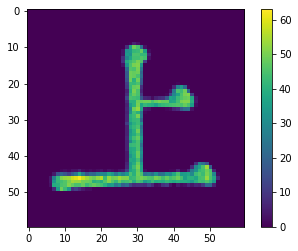

In [21]:
IMG_WIDTH = 60
IMG_HEIGHT = 60

pil_image = Image.frombytes('F', (IMG_WIDTH, IMG_HEIGHT), record[16], 'bit', 6)

np_img = np.array(pil_image)

plt.imshow(np_img)
plt.colorbar()

# Convert image to grayscale `[0-255]` range

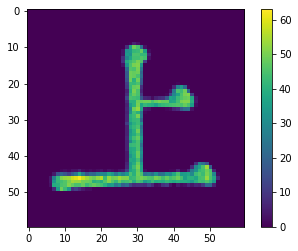

In [25]:
pil_image = pil_image.convert('L')
np_img = np.array(pil_image)

plt.imshow(np_img)
plt.colorbar()

In [23]:
import io

In [26]:
buffer = io.BytesIO()
pil_image.save(buffer, format='PNG')
png_encoded_image = buffer.getvalue()

In [28]:
pil_image = Image.frombytes('F', (IMG_WIDTH, IMG_HEIGHT), record[16], 'bit', 6)
pil_image = pil_image.convert('L')

buffer = io.BytesIO()
pil_image.save(buffer, format='PNG')
png_encoded_image = buffer.getvalue()

etl2_record = ETL2Record(
    index=record[0],
    source=T56(record[1]),
    character_type=''.join(map(T56, record[2:8])),
    font=''.join(map(T56, record[8:14])),
    unicode_char=CO59[tuple(record[14:16])],
    image=png_encoded_image,
)

etl2_record

{'index': 1, 'source': 'A', 'character_type': 'KANJI ', 'font': 'MINCHO', 'unicode_char': '上', 'image': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00<\x00\x00\x00<\x08\x00\x00\x00\x00\x1f\x97\x86\xae\x00\x00\x02\x12IDATx\x9c\xed\x95mk\xd4@\x10\xc7\xe7i7\xc9\xb5\x9cT\xad-\xf5\x01\xbf\xffG\x12\n\x15\x04\xc1*"w\xd7\\\xb2\xb33\xbe\xf0\xae\x90\xd6N\x8f\x08\xbe\xbay\x13\x92\xff\xfc\xb2;\xff\x9d\xdd\x058\xc61\xfe%0s\xac\x07Z\xfbv\xa9\xb7\xb7\xf5\xe9\x04zZ\xe2K\x1f\xec\xf2c\x90\x11H@\xc646i\x16\x9cJr\x17\xd2Y0.2e\xb8\x99W\xf38\x92\xe0j\xfdtB\x04\xd7\r\x16\xdf\x06,H\xa0)\xbb\x07\x15\xc7n\x03\x80\x86z$\x1ale\xf6\xc8:\x92\xfa\xfd\xdb_z1\xaa\xd9=c\xbf\x7fi\xce\x9b\xd5\xadO\x13"\xb8\x18\x15\xdb\xe7\xbd<\xb3%|\x9b&\x84\xed\xc9\xb6\xff9v\xb2%|\x7fz\xf8\xc8\x89\xd4\x1bu\x15\xc2\xf6\xb5e4\xbc\xba\x9e\xf4[8\xed\x02\xdd\x07\x04e2\xd80\n\x02M]\x8b`+\t\xd7\xc9\\\x13a\x83X\xb8\xde[\xf0<\x8c\xe3\x92\xf1\x93W\x00@\x14\xea\x12~?\x1cv.\xfd\xaa:\x00\x80\xfb\x08\x8f\xdb<r\x1b[_\x90\x07\ta\xef\xba\x0fc\xa4G\xb

# That's all for inspecting a single record in the dataset.

In [29]:
class XFormat:
    INT_SIZE = 4
    BYTE_ORDER = 'little'
    EXTENSION = '.xformat'
    ENCODING = 'utf-8'

    DATA_TYPE_BYTES = 0
    DATA_TYPE_INT = 1
    DATA_TYPE_UTF8_STRING = 2
    DATA_TYPE_LIST = 3
    DATA_TYPE_DICT = 4

    @classmethod
    def serialize_string(cls, s: str) -> bytes:
        record_data = s.encode(encoding=cls.ENCODING)
        return record_data

    @classmethod
    def deserialize_string(cls, bs: bytes) -> str:
        return bs.decode(encoding=cls.ENCODING)

    @classmethod
    def serialize_int(cls, n: int) -> bytes:
        record_data = n.to_bytes(
            length=cls.INT_SIZE,
            byteorder=cls.BYTE_ORDER,
            signed=True,
        )

        return record_data

    @classmethod
    def deserialize_int(cls, bs: bytes) -> int:
        return int.from_bytes(bs, byteorder=cls.BYTE_ORDER, signed=True)

    @classmethod
    def serialize_obj(cls, obj) -> (bytes, bytes):
        obj_type = type(obj)
        if obj_type == int:
            return bytes([cls.DATA_TYPE_INT]), cls.serialize_int(obj)
        elif obj_type == str:
            return bytes([cls.DATA_TYPE_UTF8_STRING]), cls.serialize_string(obj)
        elif obj_type == bytes:
            return bytes([cls.DATA_TYPE_BYTES]), obj
        elif obj_type == list:
            buffer = io.BytesIO()

            for value in obj:
                datatype, encoded_value = cls.serialize_obj(value)
                buffer.write(datatype)
                buffer.write(cls.serialize_int(len(encoded_value)))
                buffer.write(encoded_value)

            return bytes([cls.DATA_TYPE_LIST]), buffer.getvalue()
        elif obj_type == dict:
            buffer = io.BytesIO()

            for key in obj:
                datatype, encoded_key = cls.serialize_obj(key)
                buffer.write(datatype)
                buffer.write(cls.serialize_int(len(encoded_key)))
                buffer.write(encoded_key)

                datatype, encoded_value = cls.serialize_obj(obj[key])
                buffer.write(datatype)
                buffer.write(cls.serialize_int(len(encoded_value)))
                buffer.write(encoded_value)

            return bytes([cls.DATA_TYPE_DICT]), buffer.getvalue()
        else:
            raise Exception(f'Unsupported type {obj_type}!')
            return 0

    @classmethod
    def deserialze_obj(cls, bs: bytes, datatype: int):
        if datatype == cls.DATA_TYPE_BYTES:
            return bs
        elif datatype == cls.DATA_TYPE_INT:
            return cls.deserialize_int(bs)
        elif datatype == cls.DATA_TYPE_UTF8_STRING:
            return cls.deserialize_string(bs)
        elif datatype == cls.DATA_TYPE_LIST:
            retval = []
            buffer = io.BytesIO(bs)
            pos = 0
            bs_len = len(bs)

            while pos < bs_len:
                value_datatype = bs[pos]
                pos += 1

                if(pos + cls.INT_SIZE) > bs_len:
                    raise Exception(f'Broken serialized data!')
                value_byte_count = cls.deserialize_int(bs[pos:pos+cls.INT_SIZE])  # noqa
                pos += cls.INT_SIZE

                if(pos + value_byte_count) > bs_len:
                    raise Exception(f'Broken serialized data!')
                value = cls.deserialze_obj(bs[pos:pos+value_byte_count], value_datatype)  # noqa
                retval.append(value)
                pos += value_byte_count

            return retval
        elif datatype == cls.DATA_TYPE_DICT:
            retval = {}
            buffer = io.BytesIO(bs)
            pos = 0
            bs_len = len(bs)

            while pos < bs_len:
                key_datatype = bs[pos]
                pos += 1

                if (pos + cls.INT_SIZE) > bs_len:
                    raise Exception(f'Broken serialized data!')
                key_byte_count = cls.deserialize_int(bs[pos:pos+cls.INT_SIZE])
                pos += cls.INT_SIZE

                if(pos + key_byte_count) > bs_len:
                    raise Exception(f'Broken serialized data!')
                key = cls.deserialze_obj(bs[pos:pos+key_byte_count], key_datatype)  # noqa
                pos += key_byte_count

                value_datatype = bs[pos]
                pos += 1

                if(pos + cls.INT_SIZE) > bs_len:
                    raise Exception(f'Broken serialized data!')
                value_byte_count = cls.deserialize_int(bs[pos:pos+cls.INT_SIZE])  # noqa
                pos += cls.INT_SIZE

                if(pos + value_byte_count) > bs_len:
                    raise Exception(f'Broken serialized data!')
                value = cls.deserialze_obj(bs[pos:pos+value_byte_count], value_datatype)  # noqa
                pos += value_byte_count

                retval[key] = value

            return retval
        else:
            raise Exception(f'Unsupported data type {datatype}!')

In [31]:
import json

In [30]:
from tqdm import tqdm

In [37]:
records_metadata = []
etl2_serialized_dataset_filepath = f'etl2{XFormat.EXTENSION}'

with open(etl2_serialized_dataset_filepath, mode='wb') as out_stream:
    pbar = tqdm(etl2_filepaths)
    for filename in pbar:

        file_stream = bitstring.ConstBitStream(filename=filename)

        while True:
            try:
                record = file_stream.readlist('int:36,uint:6,pad:30,6*uint:6,6*uint:6,pad:24,2*uint:6,pad:180,bytes:2700')
            except:
                # TODO properly check for end of file
                # print(record)
                # traceback.print_exc()
                break

            pil_image = Image.frombytes('F', (IMG_WIDTH, IMG_HEIGHT), record[16], 'bit', 6)
            pil_image = pil_image.convert('L')

            buffer = io.BytesIO()
            pil_image.save(buffer, format='PNG')
            png_encoded_image = buffer.getvalue()

            etl2_record = ETL2Record(
                index=record[0],
                source=T56(record[1]),
                character_type=''.join(map(T56, record[2:8])),
                font=''.join(map(T56, record[8:14])),
                unicode_char=CO59[tuple(record[14:16])],
                image=png_encoded_image,
            )

            record_datatype, serialized_record = XFormat.serialize_obj(etl2_record.__dict__)
            record_byte_count = len(serialized_record)
            record_seek_start = out_stream.tell()

            out_stream.write(record_datatype)
            out_stream.write(XFormat.serialize_int(record_byte_count))
            out_stream.write(serialized_record)

            record_seek_end = out_stream.tell()
            
            record_metadata = {
                'index': etl2_record.index,
                'source': etl2_record.source,
                'character_type': etl2_record.character_type,
                'font': etl2_record.font,
                'unicode_char': etl2_record.unicode_char,
                'seek_start': record_seek_start,
                'seek_end': record_seek_end,
            }
            
            records_metadata.append(record_metadata)
            
            pbar.set_description(f'{filename} - {etl2_record.index}')

ETL2/ETL2_5 - 57600: 100%|████████████████████████████████████████████████████████████| 5/5 [01:42<00:00, 20.42s/it]


In [38]:
with open('etl2-metadata.json', mode='w', encoding='utf-8') as out_stream:
    json.dump(records_metadata, out_stream, ensure_ascii=False, indent='\t')